## Objective

In this study, we develop a model to predict the category of a consumer finance complaint based on known data (supervised learning).  
The data is taken from [data.gov](https://catalog.data.gov/dataset/consumer-complaint-database).  
Text analysis,multiclass classification and and error analysis is done using `Scikit-Learn`.

## Data exploration

In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 8, 6

In [31]:
df = pd.read_csv('Consumer_Complaints.csv', nrows=10000)   # Taking 10000 rows due to memory limit and fast processing
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,10/01/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/05/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760


## Imbalance in classes

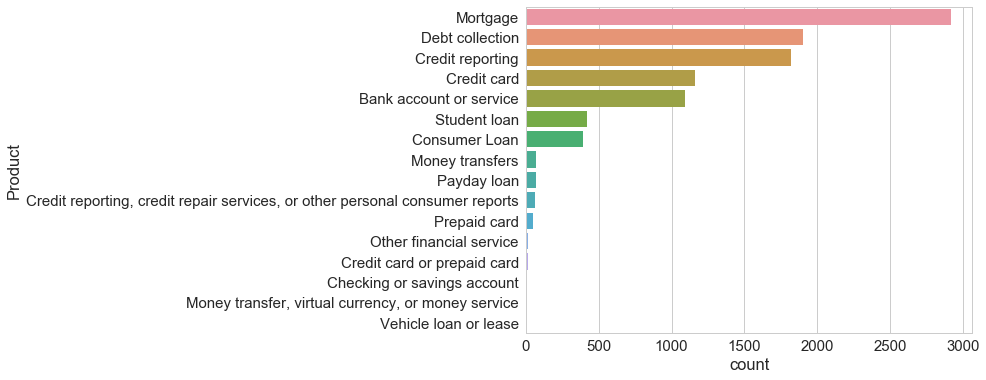

In [32]:
prodcount = sns.countplot(y='Product', data=df, order = df['Product'].value_counts().index)

We see that the number of complaints per product is imbalanced. Consumers’ complaints are more biased towards Debt collection, Mortgage and Credit reporting.  
In this case of learning imbalanced data, the majority classes might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes. Therefore, it is left as it is.

I am removing the products after _Prepaid card_ for a cleaner view. Also they are less significant. 

In [33]:
df = df[df.Product!='Credit reporting, credit repair services, or other personal consumer reports']
df = df[df.Product!='Other financial service']
df = df[df.Product!='Money transfer, virtual currency, or money service']
df = df[df.Product!='Checking or savings account']
df = df[df.Product!='Vehicle loan or lease']
df = df[df.Product!='Credit card or prepaid card']

We need only two columns: “Product” and “Consumer complaint narrative”.

   *  Input: Consumer_complaint_narrative
   *  Output: product
   
Remove missing values in “Consumer complaints narrative” column, and add a column encoding the product as an integer because categorical variables are often better represented by integers than strings.  

Create a couple of dictionaries for future use.

In [34]:
from io import StringIO
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [35]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [36]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [37]:
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
#category_id_df

In [38]:
category_to_id = dict(category_id_df.values)
#category_to_id

In [39]:
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
#id_to_category

In [40]:
df.head()

,Product,Consumer_complaint_narrative,category_id
1,Credit reporting,I have outdated information on my credit repor...,0
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...,1
7,Credit reporting,An account on my credit report has a mistaken ...,0
12,Debt collection,This company refuses to provide me verificatio...,2
16,Debt collection,This complaint is in regards to Square Two Fin...,2


## Text representation

Texts are converted to numerical features.

** Bag of words:** a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.  

We calculate Term Frequency, Inverse Document Frequency, abbreviated to tf-idf for each term in the dataset. We use `sklearn.feature_extraction.text.TfidfVectorizer` to calculate a `tf-idf` vector for each of consumer complaint narratives with the following conditions:  

* `sublinear_df` is set to True to use a logarithmic form for frequency.
* `min_df` is the minimum numbers of documents a word must be present in to be kept.
* `norm` is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
* `ngram_range` is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
* `stop_words` is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(2096, 6042)

Each of 2096 consumer complaint narratives is represented by 6042 features. representing the tf-idf score for different unigrams and bigrams.

## What are the terms correlated most to each product?

We use `sklearn.feature_selection.chi2` to find the terms that are the most correlated with each of the products.

In [42]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  Most correlated unigrams:
. deposited
. atm
  Most correlated bigrams:
. overdraft fees
. checking account
# 'Consumer Loan':
  Most correlated unigrams:
. car
. vehicle
  Most correlated bigrams:
. personal loan
. ally financial
# 'Credit card':
  Most correlated unigrams:
. citi
. card
  Most correlated bigrams:
. annual fee
. credit card
# 'Credit reporting':
  Most correlated unigrams:
. experian
. equifax
  Most correlated bigrams:
. information credit
. credit report
# 'Debt collection':
  Most correlated unigrams:
. collection
. debt
  Most correlated bigrams:
. debt collector
. collection agency
# 'Money transfers':
  Most correlated unigrams:
. paypal
. western
  Most correlated bigrams:
. western union
. send money
# 'Mortgage':
  Most correlated unigrams:
. modification
. mortgage
  Most correlated bigrams:
. mortgage company
. loan modification
# 'Payday loan':
  Most correlated unigrams:
. 95
. payday
  Most correlated bigrams:
. pay day
. pa

Overall the unigrams and bigrams make sense for each category of product.  

## Multiclass classifier

### Features and design

* To work on obtaining a model, we first transform the “Consumer complaint narrative” into a vector of numbers. We use the TF-IDF weighted vector representation.  
* After getting the vector representation, we use Naive Bayes classifier to train the model for multiclass classification. 

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

Test prediction based on the model:

In [44]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [45]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer_complaint_narrative,category_id
12,Debt collection,This company refuses to provide me verificatio...,2


## Model selection

Benchmarking the following four models:

* Logistic Regression
* (Multinomial) Naive Bayes
* Linear Support Vector Machine
* Random Forest

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    ]

CV = 5 # Cross validation

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

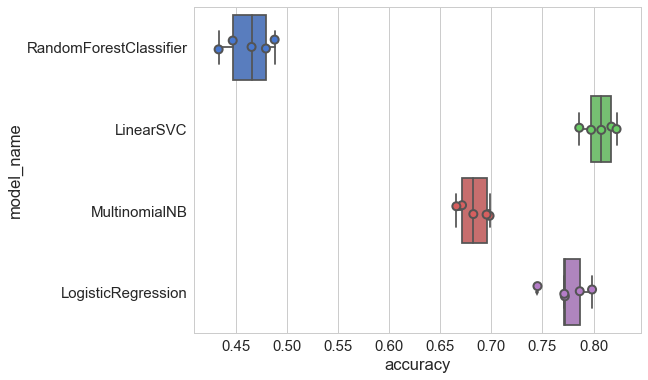

In [47]:
sns.boxplot(y='model_name', x='accuracy', data=cv_df)
sns.stripplot(y='model_name', x='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [48]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.806271
LogisticRegression        0.774748
MultinomialNB             0.682708
RandomForestClassifier    0.462755
Name: accuracy, dtype: float64

LinearSVC and Logistic Regression perform better than the other two classifiers, with LinearSVC having a slight advantage with a mean accuracy of around 80%.

## Model evaluation with confusion matrix 

Confusion matrix with best model (LinearSVC):

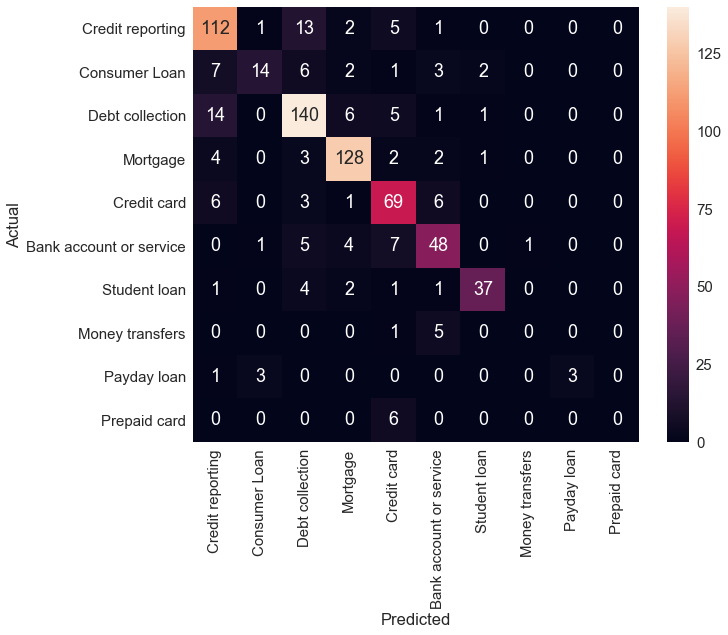

In [51]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, 
                                                                                 random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. However, there are a number of misclassifications i.e. erros in off diagonal elements. Let us  look at some of these errors.  

## Error analysis

In [53]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
            print('')

'Debt collection' predicted as 'Credit reporting' : 14 examples.


,Product,Consumer_complaint_narrative
7677,Debt collection,I called XXXX & XXXX and was told the account ...
5273,Debt collection,"XXXX XXXX, XXXX ( This letter describes in det..."
9026,Debt collection,I pulled my credit report and there was an acc...
5533,Debt collection,they have kept dispute ongoing for more tan 14...
8287,Debt collection,There is a collection listed which is unknown ...
6570,Debt collection,the Hippa law as been violated as my medical i...
3370,Debt collection,I would like to ask for your assistance in thi...
256,Debt collection,I have asked real time solutions several times...
3834,Debt collection,XXXX companies reporting same information on c...
2245,Debt collection,Original Institution XXXX XXXX which has been ...



'Credit reporting' predicted as 'Debt collection' : 13 examples.


,Product,Consumer_complaint_narrative
2497,Credit reporting,I have never had any agreement with this compa...
4746,Credit reporting,"XXXX account # XXXX I have insurance, I paid m..."
9568,Credit reporting,According to the Fair Credit Reporting section...
361,Credit reporting,I mailed out a letter and followed the instruc...
2845,Credit reporting,XXXX is misreporting an account I had with the...
7263,Credit reporting,In XX/XX/XXXX I moved to an area XXXX does not...
5846,Credit reporting,Requested bureau remove account as it was not ...
8617,Credit reporting,My social security number was stolen along wit...
1009,Credit reporting,A original debt when into collections from XXX...
210,Credit reporting,XXXX has wrongfully placed an account in colle...


Some of the misclassified complaints are complaints that touch on more than one subjects (for example, complaints involving both credit card and credit report). This sort of errors will always happen.  

We use the chi-squared test again to find the terms that are the most correlated with each of the categories:

In [58]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("Top unigrams:\n . {}".format('\n . '.join(unigrams)))
  print("Top bigrams:\n . {}".format('\n . '.join(bigrams)))

# 'Bank account or service':
Top unigrams:
 . bank
 . account
Top bigrams:
 . debit card
 . sent money
# 'Consumer Loan':
Top unigrams:
 . vehicle
 . car
Top bigrams:
 . 2600 00
 . personal loan
# 'Credit card':
Top unigrams:
 . card
 . discover
Top bigrams:
 . credit card
 . synchrony bank
# 'Credit reporting':
Top unigrams:
 . equifax
 . transunion
Top bigrams:
 . xxxx account
 . xxxx reported
# 'Debt collection':
Top unigrams:
 . debt
 . collection
Top bigrams:
 . stop calling
 . accounts xxxx
# 'Money transfers':
Top unigrams:
 . transfer
 . money
Top bigrams:
 . send money
 . western union
# 'Mortgage':
Top unigrams:
 . mortgage
 . escrow
Top bigrams:
 . mortgage company
 . mortgage payment
# 'Payday loan':
Top unigrams:
 . payday
 . loan
Top bigrams:
 . payday loan
 . pay day
# 'Prepaid card':
Top unigrams:
 . prepaid
 . serve
Top bigrams:
 . use card
 . provisional credit
# 'Student loan':
Top unigrams:
 . navient
 . loans
Top bigrams:
 . student loan
 . student loans


Overall the unigrams and bigrams after fitting the model make sense for each category of product.

## Classification report

Classification report for each class:

In [59]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                         precision    recall  f1-score   support

       Credit reporting       0.77      0.84      0.80       134
          Consumer Loan       0.74      0.40      0.52        35
        Debt collection       0.80      0.84      0.82       167
               Mortgage       0.88      0.91      0.90       140
            Credit card       0.71      0.81      0.76        85
Bank account or service       0.72      0.73      0.72        66
           Student loan       0.90      0.80      0.85        46
        Money transfers       0.00      0.00      0.00         6
            Payday loan       1.00      0.43      0.60         7
           Prepaid card       0.00      0.00      0.00         6

            avg / total       0.79      0.80      0.79       692



C:\Users\Manjit\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Rerefences

* Original article on consumer complaint classification by [Susan L.](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f)
* About tf-idf in [Quora](https://www.quora.com/How-does-TfidfVectorizer-work-in-laymans-terms) and [wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
* About [oversampling and undersampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis)